For this homework, I have chosen a prebuilt dataset within TensorFlow and it is named fashion_mnist.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity

# Load MNIST dataset
(X_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

fashion_mnist dataset consists of 10 different classes for clothing and outfits. Here is a description of shape and features of dataset:

In [34]:
# Display dataset information
print("MNIST Dataset Information:")
print("-" * 30)
print(f"{'Training Set Shape':<25}{str(X_train.shape):<30}{str(y_train.shape):<25}")
print(f"{'Image Size':<25}{str(X_train.shape[1:]):<30}")
print(f"{'Number of Classes':<25}{len(np.unique(y_train)):<30}")
print("-" * 30)

MNIST Dataset Information:
------------------------------
Training Set Shape       (60000, 28, 28)               (60000,)                 
Image Size               (28, 28)                      
Number of Classes        10                            
------------------------------


Here are the first ten images within each class in the dataset.

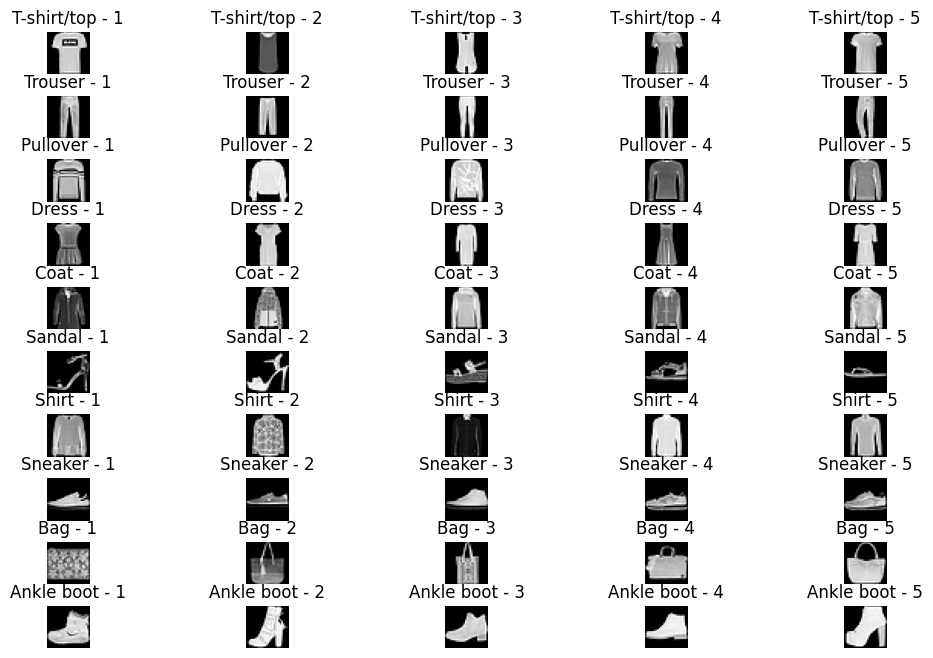

In [35]:
# Map class labels to category names
category_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Display the first five images for each class


# Display the first five images for each class
def display_images(images, labels, num_images=5):
    num_classes = len(np.unique(labels))
    fig, axs = plt.subplots(num_classes, num_images, figsize=(12, 8))

    # Adjust space between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    for i in range(num_classes):
        class_indices = np.where(labels == i)[0][:num_images]
        for j, idx in enumerate(class_indices):
            axs[i, j].imshow(images[idx], cmap='gray')
            axs[i, j].set_title(f"{category_names.get(i)} - {j + 1}")
            axs[i, j].axis("off")

    plt.show()

# Display the first five images for each class
display_images(X_train, y_train)

This dataset is very large with many samples so Google Colab does not let us use clustering methods with the whole set. I will take a subset of the dataset to work with

In [36]:
# Select the first 200 samples from each class
samples_per_class = 200
X_train_selected = []
y_train_selected = []

for class_label in np.unique(y_train):
    class_indices = np.where(y_train == class_label)[0][:samples_per_class]
    X_train_selected.append(X_train[class_indices])
    y_train_selected.append(y_train[class_indices])

X_train_selected = np.concatenate(X_train_selected, axis=0)
y_train_selected = np.concatenate(y_train_selected, axis=0)

Then we will flatten the array and normalize it here. Flattening the array simplifies the input representation. We normalize our data because especially Kmeans method is sensitive to the scaling of the data. It is a good practice to flatten and normalize.

In [37]:
# Reshape and normalize the data
X_train_flat = X_train_selected.reshape((len(X_train_selected), -1))
X_train_normalized = X_train_flat.astype('float32') / 255.0

I will apply clustering using Kmeans, Agglomerate and DBSCAN. We know that there are 10 different clusters, therefore it is easier to set the parameters for the Kmeans and Agglomerate methods. However, DBSCAN's eps argument is a little more trickier than setting a cluster number. To achieve the optimal value, we will run a series of eps values and take the optimal one:

In [38]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train_normalized)

# Apply Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=10)
agglomerative_labels = agglomerative.fit_predict(X_train_normalized)

# Apply DBSCAN
dbscan = ""
max_score_eps = 0
max_dbscan_score = -10
for i in np.linspace(0.5, 10, 10):
    dbscan = DBSCAN(eps=i, min_samples=10)
    dbscan_labels = dbscan.fit_predict(X_train_normalized)
    dbscan_score = adjusted_rand_score(y_train_selected, dbscan_labels)
    if dbscan_score >= max_dbscan_score:
        max_score_eps = i
        max_dbscan_score = dbscan_score
    else:
        break
    print(f"DBSCAN Adjusted Rand Score: {dbscan_score}, eps = {i}")

dbscan = DBSCAN(eps=max_score_eps, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_train_normalized)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


DBSCAN Adjusted Rand Score: 0.0, eps = 0.5
DBSCAN Adjusted Rand Score: 0.0, eps = 1.5555555555555556
DBSCAN Adjusted Rand Score: 0.0, eps = 2.611111111111111
DBSCAN Adjusted Rand Score: 0.015175407583727997, eps = 3.666666666666667
DBSCAN Adjusted Rand Score: 0.05367382235260635, eps = 4.722222222222222


Since we know the original labels for the samples, we can look at the ARI score to check whether the clustering was reasonable:

In [39]:
# Display ARI scores
ari_kmeans = adjusted_rand_score(y_train_selected, kmeans_labels)
ari_agglomerative = adjusted_rand_score(y_train_selected, agglomerative_labels)
ari_dbscan = adjusted_rand_score(y_train_selected, dbscan_labels)
print("ARI Scores:")
print(f"K-Means: {ari_kmeans:.4f}")
print(f"Agglomerative: {ari_agglomerative:.4f}")
print(f"DBSCAN: {ari_dbscan:.4f}")

ARI Scores:
K-Means: 0.3555
Agglomerative: 0.4163
DBSCAN: 0.0537


By default, we seem to achieve the best clustering with Agglomerative method. After this step, I will plot the clustering results using t-SNE method.

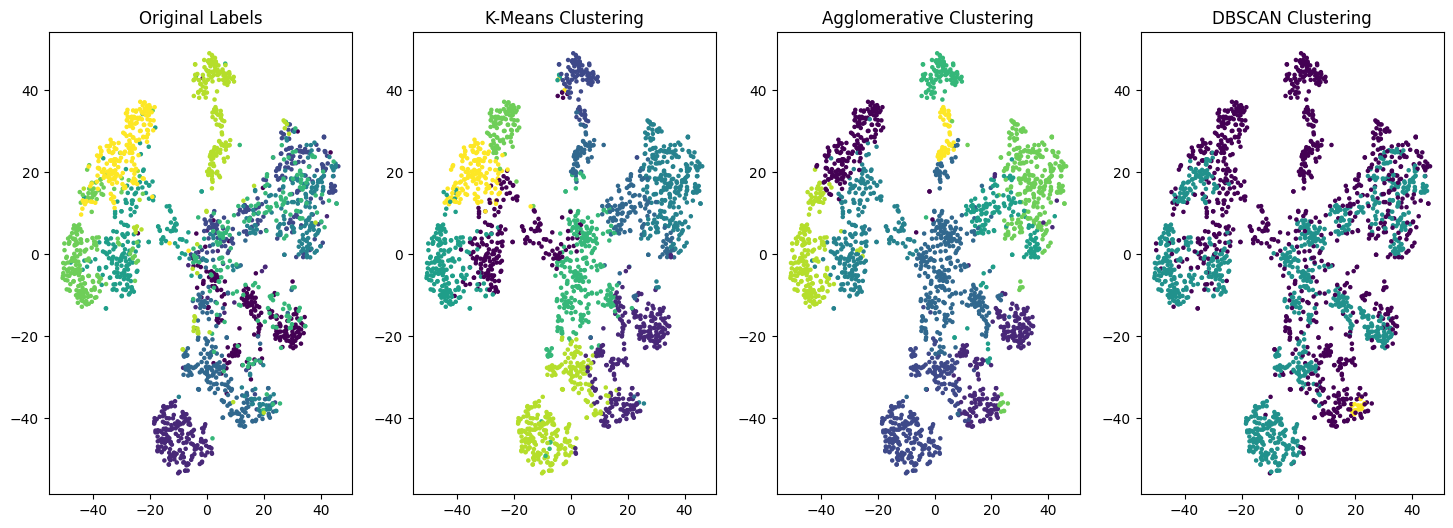

In [40]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(X_train_normalized)

# Plot results of K-Means clustering using t-SNE
plt.figure(figsize=(18, 6))
plt.subplot(1, 4, 1)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1],
            c=y_train_selected, cmap='viridis', s=5)
plt.title('Original Labels')

# Plot results of K-Means clustering using t-SNE
plt.subplot(1, 4, 2)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=kmeans_labels, cmap='viridis', s=5)
plt.title('K-Means Clustering')

# Plot results of Agglomerative Clustering using t-SNE
plt.subplot(1, 4, 3)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1],
            c=agglomerative_labels, cmap='viridis', s=5)
plt.title('Agglomerative Clustering')

# Plot results of DBSCAN using t-SNE
plt.subplot(1, 4, 4)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=dbscan_labels, cmap='viridis', s=5)
plt.title('DBSCAN Clustering')

plt.show()

By realizing that taking more or fewer samples may lead to an increase or a decrease for ARI score, I have experimented with different dataset sizes and noticed that using 1000 samples for each class instead of 200 results in a higher score of ARI. This change in the sample size affects our results because for Kmeans the cluster center changes and with Agglomerative clustering, when there are more samples, the forming of the clusters will change because of the proximity of the samples. I will run the code above again for 1000 samples now.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


DBSCAN Adjusted Rand Score: 0.0, eps = 0.5
DBSCAN Adjusted Rand Score: 0.0, eps = 1.5555555555555556
DBSCAN Adjusted Rand Score: 0.001504422619016509, eps = 2.611111111111111
DBSCAN Adjusted Rand Score: 0.04796228410507634, eps = 3.666666666666667
ARI Scores:
K-Means: 0.3519
Agglomerative: 0.4684
DBSCAN: 0.0480


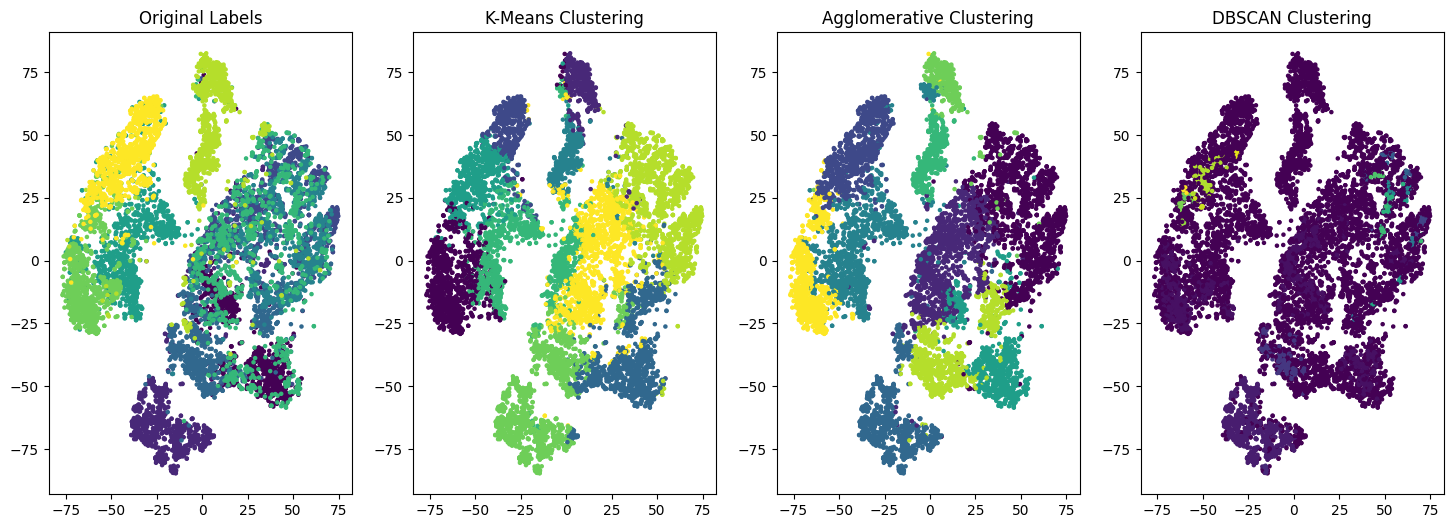

In [41]:
# Select the first 1000 samples from each class
samples_per_class = 1000
X_train_selected = []
y_train_selected = []

for class_label in np.unique(y_train):
    class_indices = np.where(y_train == class_label)[0][:samples_per_class]
    X_train_selected.append(X_train[class_indices])
    y_train_selected.append(y_train[class_indices])

X_train_selected = np.concatenate(X_train_selected, axis=0)
y_train_selected = np.concatenate(y_train_selected, axis=0)

# Reshape and normalize the data
X_train_flat = X_train_selected.reshape((len(X_train_selected), -1))
X_train_normalized = X_train_flat.astype('float32') / 255.0

# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train_normalized)

# Apply Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=10)
agglomerative_labels = agglomerative.fit_predict(X_train_normalized)

# Apply DBSCAN
dbscan = ""
max_score_eps = 0
max_dbscan_score = -10
for i in np.linspace(0.5, 10, 10):
    dbscan = DBSCAN(eps=i, min_samples=10)
    dbscan_labels = dbscan.fit_predict(X_train_normalized)
    dbscan_score = adjusted_rand_score(y_train_selected, dbscan_labels)
    if dbscan_score >= max_dbscan_score:
        max_score_eps = i
        max_dbscan_score = dbscan_score
    else:
        break
    print(f"DBSCAN Adjusted Rand Score: {dbscan_score}, eps = {i}")

dbscan = DBSCAN(eps=max_score_eps, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_train_normalized)

# Display ARI scores
ari_kmeans = adjusted_rand_score(y_train_selected, kmeans_labels)
ari_agglomerative = adjusted_rand_score(y_train_selected, agglomerative_labels)
ari_dbscan = adjusted_rand_score(y_train_selected, dbscan_labels)
print("ARI Scores:")
print(f"K-Means: {ari_kmeans:.4f}")
print(f"Agglomerative: {ari_agglomerative:.4f}")
print(f"DBSCAN: {ari_dbscan:.4f}")

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(X_train_normalized)

# Plot results of K-Means clustering using t-SNE
plt.figure(figsize=(18, 6))
plt.subplot(1, 4, 1)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1],
            c=y_train_selected, cmap='viridis', s=5)
plt.title('Original Labels')

# Plot results of K-Means clustering using t-SNE
plt.subplot(1, 4, 2)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=kmeans_labels, cmap='viridis', s=5)
plt.title('K-Means Clustering')

# Plot results of Agglomerative Clustering using t-SNE
plt.subplot(1, 4, 3)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1],
            c=agglomerative_labels, cmap='viridis', s=5)
plt.title('Agglomerative Clustering')

# Plot results of DBSCAN using t-SNE
plt.subplot(1, 4, 4)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=dbscan_labels, cmap='viridis', s=5)
plt.title('DBSCAN Clustering')

plt.show()

Agglomerative clustering method has some parameters to play around. One of these parameters is the linkage. It is set to "ward" by default. Here are different results with different linkage methods.

In [42]:
# Apply Agglomerative Clustering with complete linkage
agglomerative_complete = AgglomerativeClustering(n_clusters=10, linkage="complete")
agglomerative_labels_complete = agglomerative_complete.fit_predict(X_train_normalized)

# Apply Agglomerative Clustering with average linkage
agglomerative_average = AgglomerativeClustering(n_clusters=10, linkage="average")
agglomerative_labels_average = agglomerative_average.fit_predict(X_train_normalized)

# Apply Agglomerative Clustering with complete sinlge
agglomerative_single = AgglomerativeClustering(n_clusters=10, linkage="single")
agglomerative_labels_single = agglomerative_single.fit_predict(X_train_normalized)


ari_agglomerative_complete = adjusted_rand_score(y_train_selected, agglomerative_labels_complete)
ari_agglomerative_average = adjusted_rand_score(y_train_selected, agglomerative_labels_average)
ari_agglomerative_single = adjusted_rand_score(y_train_selected, agglomerative_labels_single)

print("ARI Scores:")
print(f"Agglomerative with complete linkage: {ari_agglomerative_complete:.4f}")
print(f"Agglomerative with average linkage: {ari_agglomerative_average:.4f}")
print(f"Agglomerative with single linkage: {ari_agglomerative_single:.4f}")

ARI Scores:
Agglomerative with complete linkage: 0.2350
Agglomerative with average linkage: 0.1751
Agglomerative with single linkage: 0.0000


After these results, I concluded that the Agglomerative clustering with default parameters is working fine without adjustments.

After the previous steps, I want to check for similar images in the selected dataset after I upload a new image. My new image is a Pullover and again has 28x28 dimensions

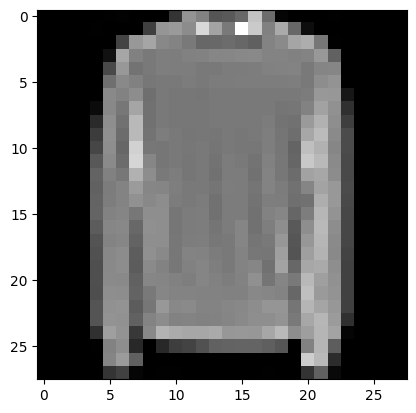

Dimensions of the image: (28, 28)


In [43]:
new_image_path = '/content/Class_2_1.png'
new_image = plt.imread(new_image_path)

# Convert the image to grayscale if needed
if new_image.ndim == 3:
    new_image = np.mean(new_image, axis=-1)

# Ensure the new image has the same size as the images in the training dataset
new_image_normalized = new_image.astype('float32') / 255.0
new_image_flat = new_image_normalized.reshape((-1,))

plt.imshow(new_image_normalized, cmap="gray")
plt.show()

print(f"Dimensions of the image: {new_image_normalized.shape}")

In scikit learn, there are different methods to check the similarities. cosine_similarity() function is one of them. I will apply cosine_similarity() to filter the similar images to the one above and display the first 10.

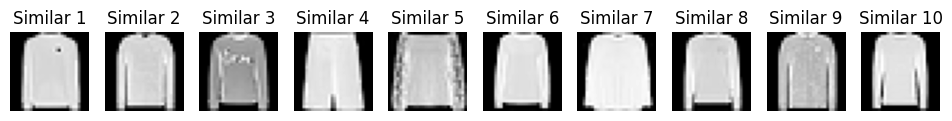

In [44]:
# Calculate cosine similarity between the new image and the previous data
cosine_similarities = cosine_similarity(
    [new_image_flat], X_train_normalized).flatten()

# Identify the most similar images based on cosine similarity
num_similar_images = 10
most_similar_indices = np.argsort(
    cosine_similarities)[-num_similar_images:][::-1]

# Display the most similar images
plt.figure(figsize=(12, 3))
for i, idx in enumerate(most_similar_indices):
    plt.subplot(1, num_similar_images, i + 1)
    plt.imshow(X_train_selected[idx].reshape((28, 28)), cmap='gray')
    plt.title(f"Similar {i + 1}")
    plt.axis("off")

plt.show()

The result is pretty good. Only the fourth item does not look like a pullover but the rest are similar to the test image.

Below is another test for a dress using the same code above.

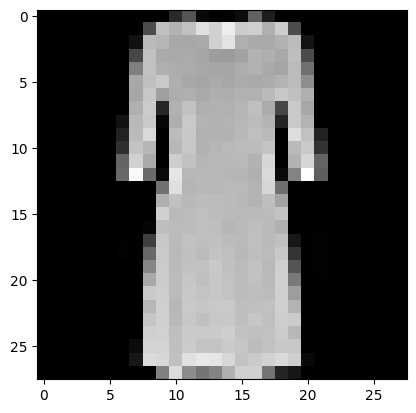

Original label of the image: Dress
Dimensions of the image: (28, 28)


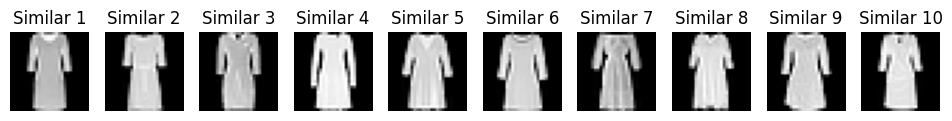

In [45]:
new_image_path = '/content/Class_3_9.png'
new_image = plt.imread(new_image_path)

# Convert the image to grayscale if needed
if new_image.ndim == 3:
    new_image = np.mean(new_image, axis=-1)

# Ensure the new image has the same size as the images in the training dataset
new_image_normalized = new_image.astype('float32') / 255.0
new_image_flat = new_image_normalized.reshape((-1,))

plt.imshow(new_image_normalized, cmap="gray")
plt.show()

print(f"Original label of the image: Dress")
print(f"Dimensions of the image: {new_image_normalized.shape}")

# Calculate cosine similarity between the new image and the previous data
cosine_similarities = cosine_similarity(
    [new_image_flat], X_train_normalized).flatten()

# Identify the most similar images based on cosine similarity
num_similar_images = 10
most_similar_indices = np.argsort(
    cosine_similarities)[-num_similar_images:][::-1]

# Display the most similar images
plt.figure(figsize=(12, 3))
for i, idx in enumerate(most_similar_indices):
    plt.subplot(1, num_similar_images, i + 1)
    plt.imshow(X_train_selected[idx].reshape((28, 28)), cmap='gray')
    plt.title(f"Similar {i + 1}")
    plt.axis("off")

plt.show()

One for trousers.

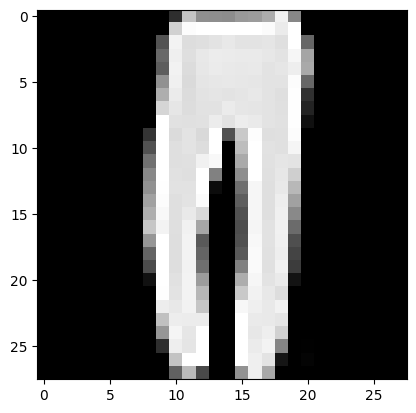

Original label of the image: Trouser
Dimensions of the image: (28, 28)


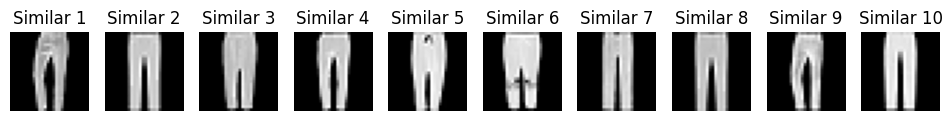

In [46]:
new_image_path = '/content/Class_1_1.png'
new_image = plt.imread(new_image_path)

# Convert the image to grayscale if needed
if new_image.ndim == 3:
    new_image = np.mean(new_image, axis=-1)

# Ensure the new image has the same size as the images in the training dataset
new_image_normalized = new_image.astype('float32') / 255.0
new_image_flat = new_image_normalized.reshape((-1,))

plt.imshow(new_image_normalized, cmap="gray")
plt.show()

print(f"Original label of the image: Trouser")
print(f"Dimensions of the image: {new_image_normalized.shape}")

# Calculate cosine similarity between the new image and the previous data
cosine_similarities = cosine_similarity(
    [new_image_flat], X_train_normalized).flatten()

# Identify the most similar images based on cosine similarity
num_similar_images = 10
most_similar_indices = np.argsort(
    cosine_similarities)[-num_similar_images:][::-1]

# Display the most similar images
plt.figure(figsize=(12, 3))
for i, idx in enumerate(most_similar_indices):
    plt.subplot(1, num_similar_images, i + 1)
    plt.imshow(X_train_selected[idx].reshape((28, 28)), cmap='gray')
    plt.title(f"Similar {i + 1}")
    plt.axis("off")

plt.show()

For this next part, I want to add the images above (dress, trouser and pullover) to the selected dataset and show the similar images within the same cluster. Since agglomerative had the highest ARI score, I will do the experiment using only this method.

Now that we know using cosine_similarity() function is a reliable way of finding similar images in this dataset. I will run the Agglomerative clustering after adding the above images one by one to the dataset and see the most similar images within the cluster itself.

Image Array dimensions : (28, 28, 4)
Gray image dimensions : (28, 28)
Flattened image dimensions : (784,)


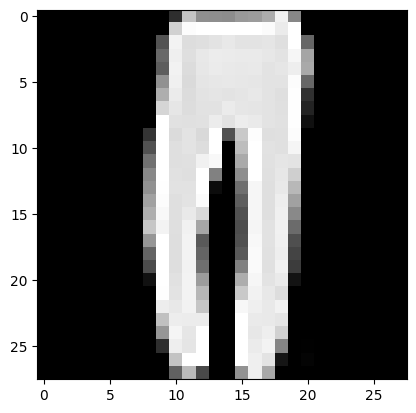

In [47]:
new_image_path = '/content/Class_1_1.png'
image_array_trouser = plt.imread(new_image_path)
print(f"Image Array dimensions : {image_array_trouser.shape}")

# Convert the image to grayscale
image_gray = np.mean(image_array_trouser, axis=-1)
print(f"Gray image dimensions : {image_gray.shape}")

# Flatten the image
image_flattened = image_gray.reshape(-1)
print(f"Flattened image dimensions : {image_flattened.shape}")

plt.imshow(image_flattened.reshape(28, 28), cmap="gray")
plt.show()

Now I will add this image, and print the first few images within the cluster where this trouser is to be found

Sample images with the added_image_agglomerative_label:


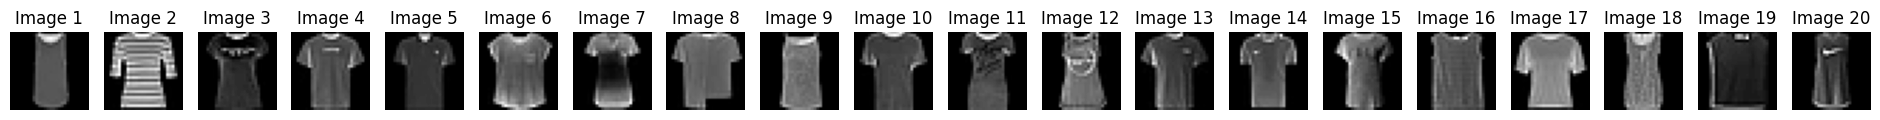

In [48]:
# Agglomerative Clustering on the updated dataset
updated_X_train = np.vstack(
    [X_train_selected.reshape((len(X_train_selected), -1)), image_flattened])
updated_agglomerative_labels = AgglomerativeClustering(
    n_clusters=10).fit_predict(updated_X_train)
added_image_agglomerative_label = updated_agglomerative_labels[-1] # We know that our added image is the last item in the set because of how vstack() works

# Identify the indices of images with the added_image_agglomerative_label
similar_images_indices = np.where(
    updated_agglomerative_labels == added_image_agglomerative_label)[0]

# Display the first 10 images with the added_image_agglomerative_label
plt.figure(figsize=(24, 6))
number_of_images_to_print = 20
print("Sample images with the added_image_agglomerative_label:")
for i in range(number_of_images_to_print):
    plt.subplot(1, number_of_images_to_print, i + 1)
    plt.imshow(updated_X_train[similar_images_indices[i]].reshape(
        28, 28), cmap="gray")
    plt.title(f"Image {i + 1}")
    plt.axis("off")

plt.show()

By observing the first 20 samples in the cluster which the trouser ended up together with, the cluster does not seem to have trousers so far. Let's see the similar images within the dataset. For this purpose, we will create a mask to identify the images in the same cluster

In [49]:
# Prepare a mask for the samples which are in the same cluster
image_cluster_mask = (updated_agglomerative_labels ==
                      added_image_agglomerative_label)
similar_images = updated_X_train[image_cluster_mask]
# Calculate similarity and sort
similarity_scores = cosine_similarity(image_flattened.reshape(
    1, -1), similar_images.reshape(similar_images.shape[0], -1))
similar_images_sorted = similar_images[np.argsort(similarity_scores[0])[::-1]]

Printing the similar images:

Printing the most similar images to the one we have added, within the same cluster


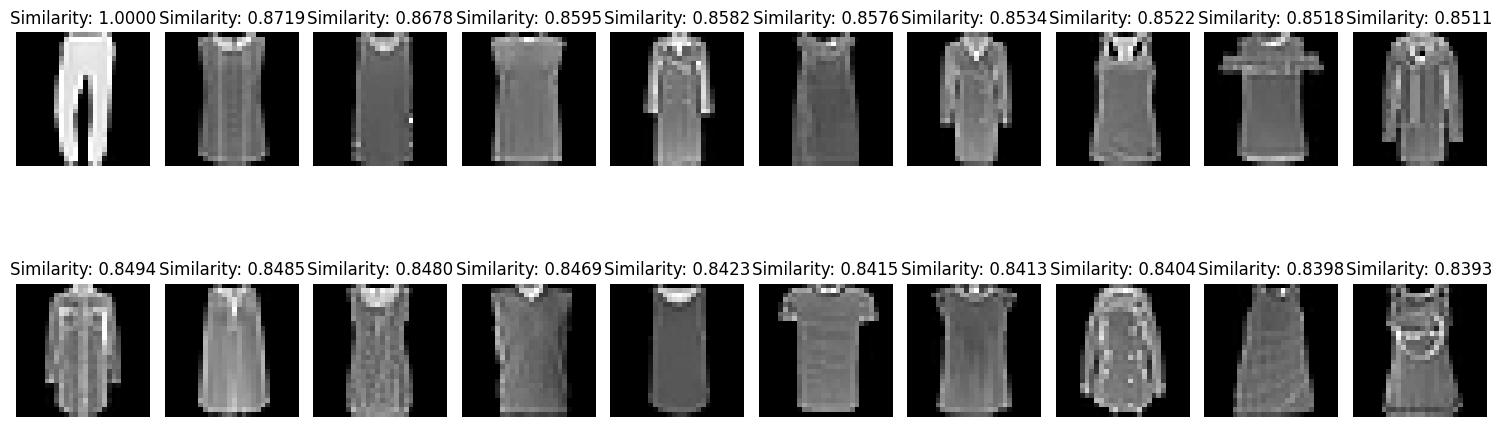

In [50]:
# Display the most similar images side by side with spacing
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed

print("Printing the most similar images to the one we have added, within the same cluster")
# Plot similar images side by side
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(similar_images_sorted[i].reshape(28, 28), cmap="gray")
    plt.title(
        f"Similarity: {similarity_scores[0][np.argsort(similarity_scores[0])[::-1]][i]:.4f}")
    plt.axis("off")

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the horizontal and vertical space between subplots
plt.tight_layout()  # Automatically adjust layout to prevent overlapping titles
plt.show()


Unfortunately, clustering algorithm was not successful and our trouser image did not end up in a cluster I hoped where there are many more trousers. We know that using cosine_similarity() actually works because similarity is maximum when the image is compared to itself and we have also observed we can find similar images when we are not restricted to the same cluster, as we have already done above with trouser, dress and pullover.

Now I will do the same procedure for dress and pullover too

Image Array dimensions : (28, 28, 4)
Gray image dimensions : (28, 28)
Flattened image dimensions : (784,)


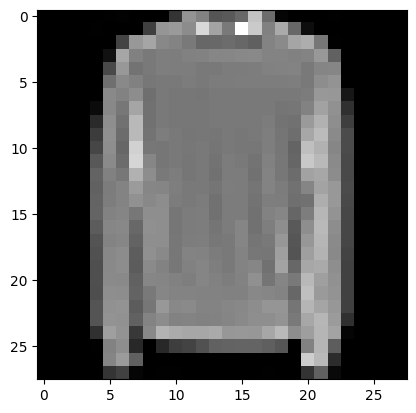

Sample images with the added_image_agglomerative_label:


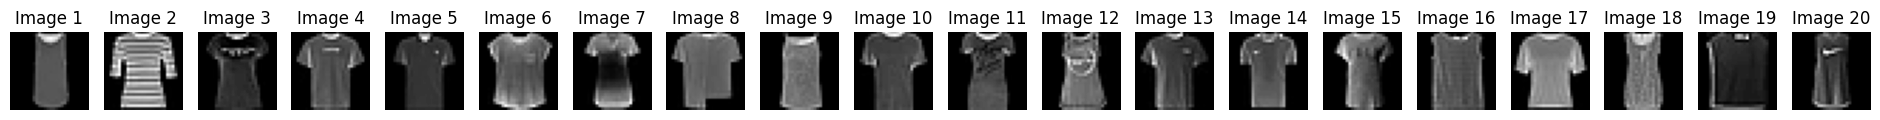

Printing the most similar images to the one we have added, within the same cluster


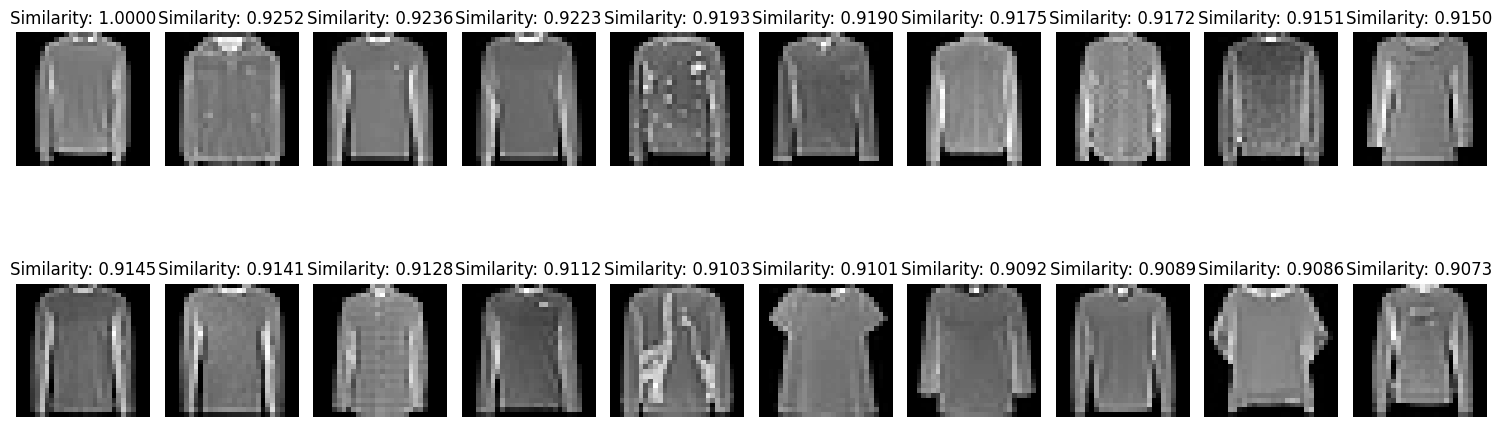

In [51]:
new_image_path = '/content/Class_2_1.png'
image_array_trouser = plt.imread(new_image_path)
print(f"Image Array dimensions : {image_array_trouser.shape}")

# Convert the image to grayscale
image_gray = np.mean(image_array_trouser, axis=-1)
print(f"Gray image dimensions : {image_gray.shape}")

# Flatten the image
image_flattened = image_gray.reshape(-1)
print(f"Flattened image dimensions : {image_flattened.shape}")

plt.imshow(image_flattened.reshape(28, 28), cmap="gray")
plt.show()

# Agglomerative Clustering on the updated dataset
updated_X_train = np.vstack(
    [X_train_selected.reshape((len(X_train_selected), -1)), image_flattened])
updated_agglomerative_labels = AgglomerativeClustering(
    n_clusters=10).fit_predict(updated_X_train)
added_image_agglomerative_label = updated_agglomerative_labels[-1]

# Identify the indices of images with the added_image_agglomerative_label
similar_images_indices = np.where(
    updated_agglomerative_labels == added_image_agglomerative_label)[0]

# Display the first 10 images with the added_image_agglomerative_label
plt.figure(figsize=(24, 6))
number_of_images_to_print = 20
print("Sample images with the added_image_agglomerative_label:")
for i in range(number_of_images_to_print):
    plt.subplot(1, number_of_images_to_print, i + 1)
    plt.imshow(updated_X_train[similar_images_indices[i]].reshape(
        28, 28), cmap="gray")
    plt.title(f"Image {i + 1}")
    plt.axis("off")

plt.show()

# Prepare a mask for the samples which are in the same cluster
image_cluster_mask = (updated_agglomerative_labels ==
                      added_image_agglomerative_label)
similar_images = updated_X_train[image_cluster_mask]
# Calculate similarity and sort
similarity_scores = cosine_similarity(image_flattened.reshape(
    1, -1), similar_images.reshape(similar_images.shape[0], -1))
similar_images_sorted = similar_images[np.argsort(similarity_scores[0])[::-1]]

# Display the most similar images side by side with spacing
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed

print("Printing the most similar images to the one we have added, within the same cluster")
# Plot similar images side by side
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(similar_images_sorted[i].reshape(28, 28), cmap="gray")
    plt.title(
        f"Similarity: {similarity_scores[0][np.argsort(similarity_scores[0])[::-1]][i]:.4f}")
    plt.axis("off")

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the horizontal and vertical space between subplots
plt.tight_layout()  # Automatically adjust layout to prevent overlapping titles
plt.show()


Our test with the pullover was much more successful. Unlike trouser, it ended up in a cluster where there are actual similar looking images.

Now another one for the dress:

Image Array dimensions : (28, 28, 4)
Gray image dimensions : (28, 28)
Flattened image dimensions : (784,)


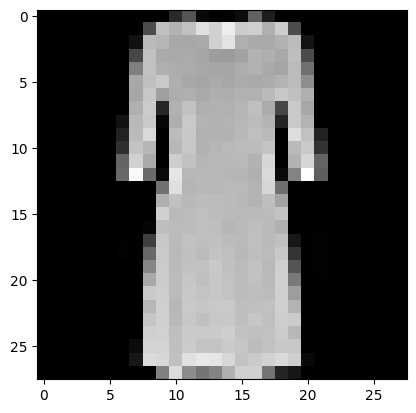

Sample images with the added_image_agglomerative_label:


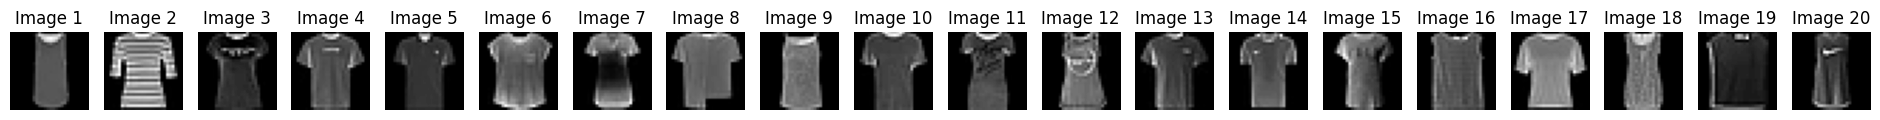

Printing the most similar images to the one we have added, within the same cluster


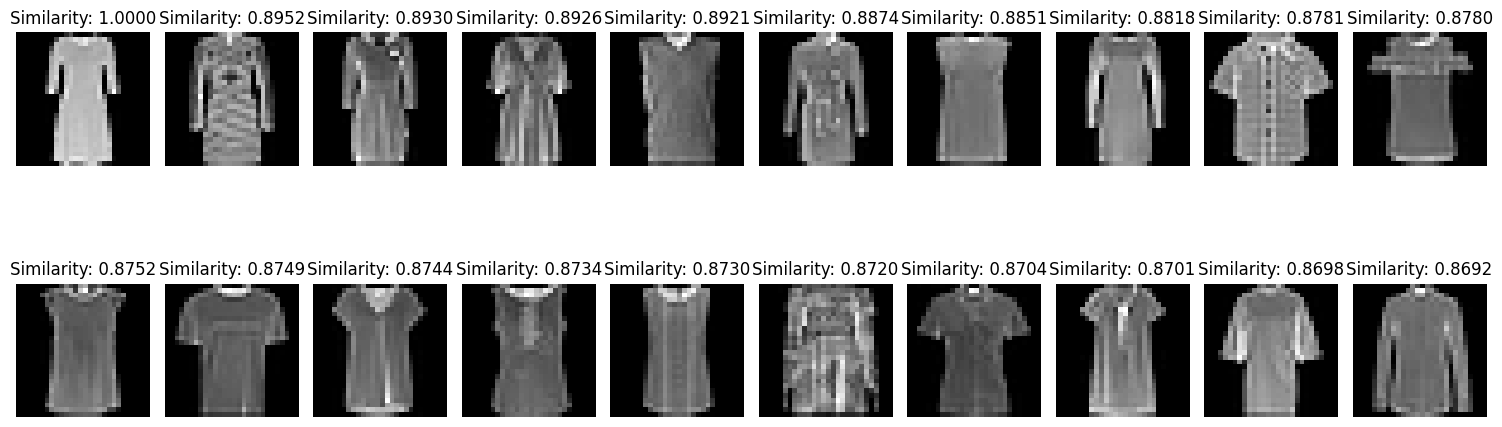

In [52]:
new_image_path = '/content/Class_3_9.png'
image_array_trouser = plt.imread(new_image_path)
print(f"Image Array dimensions : {image_array_trouser.shape}")

# Convert the image to grayscale
image_gray = np.mean(image_array_trouser, axis=-1)
print(f"Gray image dimensions : {image_gray.shape}")

# Flatten the image
image_flattened = image_gray.reshape(-1)
print(f"Flattened image dimensions : {image_flattened.shape}")

plt.imshow(image_flattened.reshape(28, 28), cmap="gray")
plt.show()

# Agglomerative Clustering on the updated dataset
updated_X_train = np.vstack(
    [X_train_selected.reshape((len(X_train_selected), -1)), image_flattened])
updated_agglomerative_labels = AgglomerativeClustering(
    n_clusters=10).fit_predict(updated_X_train)
added_image_agglomerative_label = updated_agglomerative_labels[-1]

# Identify the indices of images with the added_image_agglomerative_label
similar_images_indices = np.where(
    updated_agglomerative_labels == added_image_agglomerative_label)[0]

# Display the first 10 images with the added_image_agglomerative_label
plt.figure(figsize=(24, 6))
number_of_images_to_print = 20
print("Sample images with the added_image_agglomerative_label:")
for i in range(number_of_images_to_print):
    plt.subplot(1, number_of_images_to_print, i + 1)
    plt.imshow(updated_X_train[similar_images_indices[i]].reshape(
        28, 28), cmap="gray")
    plt.title(f"Image {i + 1}")
    plt.axis("off")

plt.show()

# Prepare a mask for the samples which are in the same cluster
image_cluster_mask = (updated_agglomerative_labels ==
                      added_image_agglomerative_label)
similar_images = updated_X_train[image_cluster_mask]
# Calculate similarity and sort
similarity_scores = cosine_similarity(image_flattened.reshape(
    1, -1), similar_images.reshape(similar_images.shape[0], -1))
similar_images_sorted = similar_images[np.argsort(similarity_scores[0])[::-1]]

# Display the most similar images side by side with spacing
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed

print("Printing the most similar images to the one we have added, within the same cluster")
# Plot similar images side by side
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(similar_images_sorted[i].reshape(28, 28), cmap="gray")
    plt.title(
        f"Similarity: {similarity_scores[0][np.argsort(similarity_scores[0])[::-1]][i]:.4f}")
    plt.axis("off")

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the horizontal and vertical space between subplots
plt.tight_layout()  # Automatically adjust layout to prevent overlapping titles
plt.show()


Image Array dimensions : (28, 28, 4)
Gray image dimensions : (28, 28)
Flattened image dimensions : (784,)


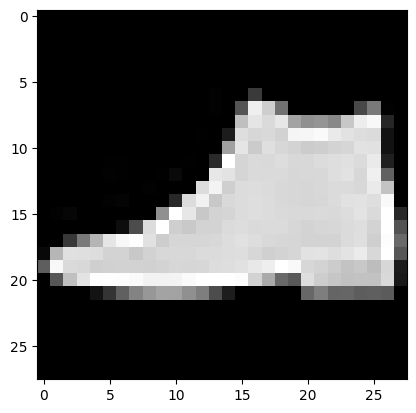

Sample images with the added_image_agglomerative_label:


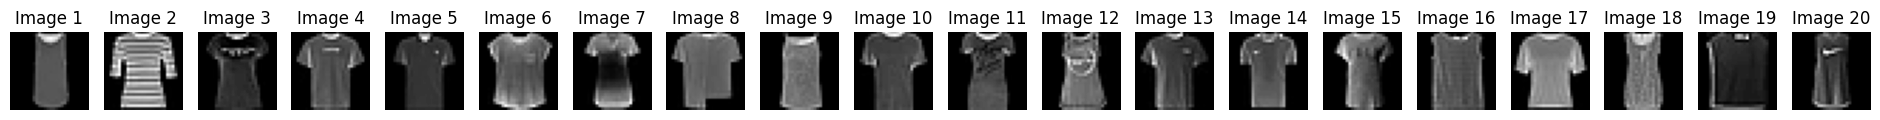

Printing the most similar images to the one we have added, within the same cluster


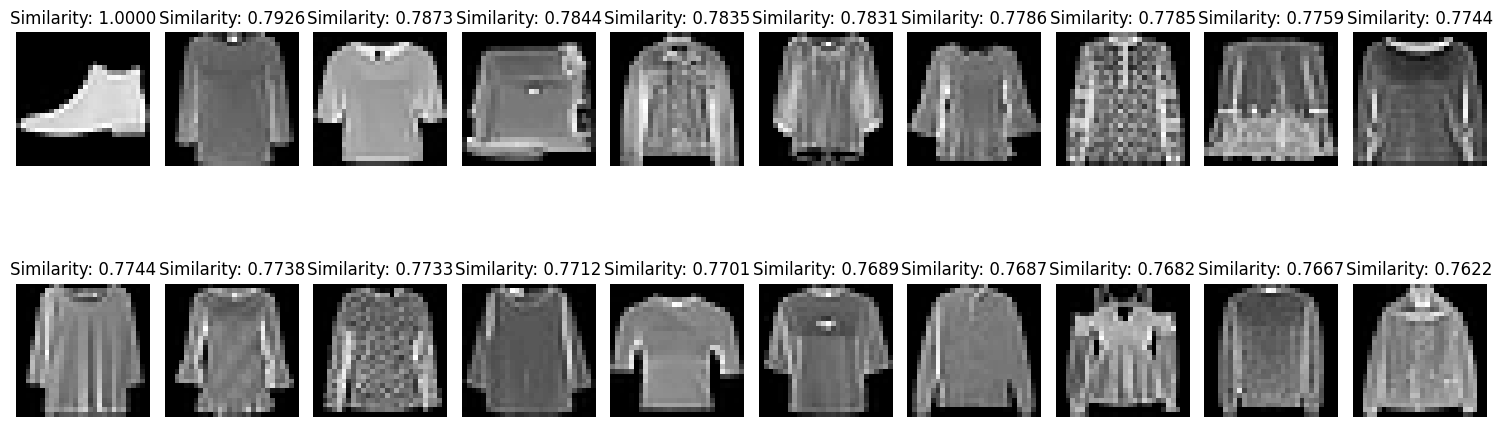

In [57]:
new_image_path = '/content/Class_9_6.png'
image_array_trouser = plt.imread(new_image_path)
print(f"Image Array dimensions : {image_array_trouser.shape}")

# Convert the image to grayscale
image_gray = np.mean(image_array_trouser, axis=-1)
print(f"Gray image dimensions : {image_gray.shape}")

# Flatten the image
image_flattened = image_gray.reshape(-1)
print(f"Flattened image dimensions : {image_flattened.shape}")

plt.imshow(image_flattened.reshape(28, 28), cmap="gray")
plt.show()

# Agglomerative Clustering on the updated dataset
updated_X_train = np.vstack(
    [X_train_selected.reshape((len(X_train_selected), -1)), image_flattened])
updated_agglomerative_labels = AgglomerativeClustering(
    n_clusters=10).fit_predict(updated_X_train)
added_image_agglomerative_label = updated_agglomerative_labels[-1]

# Identify the indices of images with the added_image_agglomerative_label
similar_images_indices = np.where(
    updated_agglomerative_labels == added_image_agglomerative_label)[0]

# Display the first 10 images with the added_image_agglomerative_label
plt.figure(figsize=(24, 6))
number_of_images_to_print = 20
print("Sample images with the added_image_agglomerative_label:")
for i in range(number_of_images_to_print):
    plt.subplot(1, number_of_images_to_print, i + 1)
    plt.imshow(updated_X_train[similar_images_indices[i]].reshape(
        28, 28), cmap="gray")
    plt.title(f"Image {i + 1}")
    plt.axis("off")

plt.show()

# Prepare a mask for the samples which are in the same cluster
image_cluster_mask = (updated_agglomerative_labels ==
                      added_image_agglomerative_label)
similar_images = updated_X_train[image_cluster_mask]
# Calculate similarity and sort
similarity_scores = cosine_similarity(image_flattened.reshape(
    1, -1), similar_images.reshape(similar_images.shape[0], -1))
similar_images_sorted = similar_images[np.argsort(similarity_scores[0])[::-1]]

# Display the most similar images side by side with spacing
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed

print("Printing the most similar images to the one we have added, within the same cluster")
# Plot similar images side by side
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(similar_images_sorted[i].reshape(28, 28), cmap="gray")
    plt.title(
        f"Similarity: {similarity_scores[0][np.argsort(similarity_scores[0])[::-1]][i]:.4f}")
    plt.axis("off")

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the horizontal and vertical space between subplots
plt.tight_layout()  # Automatically adjust layout to prevent overlapping titles
plt.show()


Out of curiosity, I also wanted to try out ankle boot after dress but it seems like it ended up in a different cluster where ankle boots are located, as we experienced with the trousers. Similarity scores between the images are also a lot lower than the other examples.


Even by using ground truth and achieving arguably a high ARI score, it will not guarantee us that our images will be in a cluster where they categorically make sense. Images are just numbers (pixels) interpreted by the code in the end and they may fall in close proximity during the clustering process, even though we perceive that they should not be there. Our perceptions of what is similar are different.